# Análise de Risco de Contribuintes utilizando Modelo Oculto de Markov (HMM)
### Trabalho de Conclusão de Curso do Curso de Pós-graduação em Ciência de Dados e Big Data - PUCMINAS <br> Autor: Miguel Castro dos Santos Junior

### OBTENÇÃO, TRATAMENTO DOS DADOS E ANÁLISE DO MODELO HMM

### Inicialização de Bibiliotecas e configuração de ambiente do Jupyter

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import locale
import sqlite3
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
pd.set_option("float_format",  lambda x: locale.format_string('%.2f', x, grouping=True))
#limite de colunas para impressão apenas, substituir por None para remover limite
pd.set_option('max_columns', 10)

### Carga dos dados da Base de Dados da Dívida Ativa

In [2]:
f = lambda s: dt.datetime.strptime(s,'%d/%m/%Y')
f1 = r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\arquivo_lai_SIDA_BA_202012.csv'
f2 = r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\arquivo_lai_SIDA_SE_202012.csv'
f3 = r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\arquivo_lai_PREV_BA_202012.csv'
f4 = r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\arquivo_lai_PREV_SE_202012.csv'
df1 = pd.read_csv (f1, sep=';', encoding='latin-1',thousands=',', decimal='.', 
                   dtype={"NUMERO_INSCRICAO":np.int64}, parse_dates=['DATA_INSCRICAO'], date_parser=f)
df2 = pd.read_csv (f2, sep=';', encoding='latin-1',thousands=',', decimal='.', 
                   dtype={"NUMERO_INSCRICAO":np.int64}, parse_dates=['DATA_INSCRICAO'], date_parser=f)
df3 = pd.read_csv (f3, sep=';', encoding='latin-1',thousands=',', decimal='.', 
                   dtype={"NUMERO_INSCRICAO":np.int64}, parse_dates=['DATA_INSCRICAO'], date_parser=f)
df4 = pd.read_csv (f4, sep=';', encoding='latin-1',thousands=',', decimal='.', 
                   dtype={"NUMERO_INSCRICAO":np.int64}, parse_dates=['DATA_INSCRICAO'], date_parser=f)
df = pd.concat([df1,df2,df3,df4], axis=0, ignore_index=True)
del df1,df2,df3,df4
df['CPF_CNPJ'].replace('\.|\/|\-','',regex=True, inplace=True)
df.insert(0,'CNPJ8',df['CPF_CNPJ'].str[:8])

### Tratamento inicial da Base de Dados da Dívida 

In [3]:
dfd = df[(df.TIPO_PESSOA == 'Pessoa jurídica') & (df.TIPO_DEVEDOR=='PRINCIPAL') 
         & (df.VALOR_CONSOLIDADO!=0) & (df.NOME_DEVEDOR!='SEM INFORMACAO')]
dfd = dfd.drop(['TIPO_PESSOA','TIPO_DEVEDOR', 'UNIDADE_RESPONSAVEL', 'TIPO_CREDITO', 'RECEITA_PRINCIPAL'], axis=1)
dfd.rename(columns={'UF_UNIDADE_RESPONSAVEL': 'UF','INDICADOR_AJUIZADO':'AJUIZADO', 
                    'VALOR_CONSOLIDADO':'VALOR'}, inplace=True)
dfd['NUMERO_INSCRICAO'] = dfd['NUMERO_INSCRICAO'].astype(str)
dfd['trimestre'] = pd.PeriodIndex(dfd['DATA_INSCRICAO'], freq='Q')
dfd.sort_values(by=['CNPJ8','DATA_INSCRICAO'], inplace=True)
dfd.dropna(inplace=True)
dfd=dfd.astype({'CNPJ8': 'string', 'CPF_CNPJ': 'string' , 'NOME_DEVEDOR': 'string', 
                'DATA_INSCRICAO':'datetime64[ns]', 'UF': 'string','NUMERO_INSCRICAO': 'int64',
                'TIPO_SITUACAO_INSCRICAO': 'string', 'SITUACAO_INSCRICAO': 'string', 'AJUIZADO': 'string'})
dfd.NUMERO_INSCRICAO.count()

516306

In [4]:
print("Valor Total da Dívida BA/SE:", locale.currency(dfd.VALOR.sum(), grouping=True))

Valor Total da Dívida BA/SE: R$ 59.187.455.235,09


In [5]:
cnpjs = dfd['CNPJ8']
cnpjs.drop_duplicates(keep='first', inplace=True)
print("Número de Contribuintes BA/SE com inscrição em Dívida Ativa: ", locale.format_string('%d',cnpjs.count(), grouping=True))

Número de Contribuintes BA/SE com inscrição em Dívida Ativa:  144.604


### Tratamento inicial da Base CNPJ e filtragem dos contribuintes com inscrição

In [6]:
conn = sqlite3.connect("e:\TCC\TCC.db")
conn.execute("DROP TABLE IF EXISTS divida")
#dfd['trimestre'] = dfd['trimestre'].astype(str)
cnpjs.to_sql("divida", conn, if_exists="append")
conn.execute("CREATE INDEX CNPJ8 ON divida(CNPJ8)")
conn.close()

In [7]:
conn = sqlite3.connect("e:\TCC\TCC.db")
dfc = pd.read_sql_query(''' select distinct cnpj, situacao, data_situacao, motivo_situacao, capital_social, porte, cnae_fiscal 
                            from empresas
                            inner join divida on divida.CNPJ8=substr(empresas.cnpj,1,8)
                            where matriz_filial=01
                            ; '''
                            , conn)
conn.close()
dfc=dfc.astype({'cnpj': 'string', 'situacao': 'int64' , 'data_situacao': 'datetime64[ns]', 'motivo_situacao': 'int64', 
                'capital_social': 'float', 'porte': 'int64', 'cnae_fiscal': 'int64'})
dfc.insert(0,'CNPJ8',dfc['cnpj'].str[:8])
dfc = dfc.drop(['cnpj'], axis=1)
dfc['capital_social'].fillna(value=0.0, inplace=True)
dfc.CNPJ8.count()

144604

### Combinação de Bases da Dívida e do CNPJ

In [8]:
# Combinação de bases de dados Dívida e CNPJ
dfd = pd.merge(dfd, dfc, how='left', on='CNPJ8')

### Processamento para geração das Classificações de Riscos dos Contribuintes

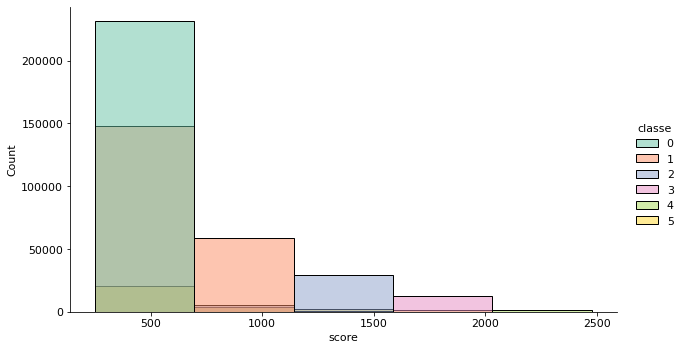

In [9]:
pesos_s = {'Em cobrança':0.4, 'Em negociação':0.3, 'Suspenso por decisão judicial':0.2,
           'Garantia':0.1, 'Benefício Fiscal':0.1}
pesos_i = {'até 1 ano': 0.1,'1 a 5 anos':0.2, 'mais de 5 anos': 0.3}
pesos_d = {'até 100 mil': 0,'100 a 1 milhão': 200,'1 a 2 milhões': 400,'2 a 10 milhões': 800, 
           '10 a 100 milhões': 1200, 'mais de 100 milhões': 1500}
pesos_a = {'SIM':0.1, 'NAO':0.2}
pesos_c = {'menor 30%':0, '30 a 100%': 200, 'mais de 100%':500}
dfd['acumulado'] = dfd.groupby(['CNPJ8','NOME_DEVEDOR'])['VALOR'].cumsum()
dfd['sit_p'] = dfd.apply(lambda x:x.VALOR * pesos_s[x.TIPO_SITUACAO_INSCRICAO], axis=1)
dfd['sit_p_acum'] = dfd.groupby(['CNPJ8','NOME_DEVEDOR'])['sit_p'].cumsum()
dfd['anos'] = round((dt.datetime.today()-dfd['DATA_INSCRICAO'])/dt.timedelta(365,5,49,12),2)
dfd['idade_c'] = pd.cut(dfd['anos'],bins=[0,1,5,5000],labels=pesos_i.values(),include_lowest=True)
dfd['idade_p'] = dfd.apply(lambda x:x.VALOR * x.idade_c, axis=1)
dfd['idade_p_acum'] = dfd.groupby(['CNPJ8','NOME_DEVEDOR'])['idade_p'].cumsum()
dfd['sit_s'] = dfd.apply(lambda x:round(x.sit_p_acum / x.acumulado *500), axis=1)
dfd['idade_s'] = dfd.apply(lambda x:round(x.idade_p_acum / x.acumulado *500), axis=1)
dfd['acum_s'] = pd.cut(dfd['acumulado'],bins=[0,100000,1000000,2000000,10000000, 100000000,float("inf")],
                       labels=pesos_d.values(),include_lowest=True)
dfd['ajuiz_c'] = dfd['AJUIZADO'].replace(pesos_a)
dfd['ajuiz_p'] = dfd.apply(lambda x:x.VALOR * x.ajuiz_c, axis=1)
dfd['ajuiz_p_acum'] = dfd.groupby(['CNPJ8','NOME_DEVEDOR'])['ajuiz_p'].cumsum()
dfd['ajuiz_s'] = dfd.apply(lambda x:round(x.ajuiz_p_acum / x.acumulado *1000), axis=1)
dfd['capital_p']= dfd.apply(lambda x:0 if x.capital_social==0.0 else round((x.acumulado / x.capital_social * 100)), axis=1)
dfd['capital_s'] = pd.cut(dfd['capital_p'],bins=[0,30,100,float("inf")],labels=pesos_c.values(),include_lowest=True)
dfd['score'] = dfd[['acum_s','idade_s','sit_s','ajuiz_s','capital_s']].sum(axis=1)
dfd['classe1'] = pd.cut(dfd['score'],bins=[0,500,1000,1500,2000,float("inf")],labels=[0,1,2,3,4],include_lowest=True)
dfd['classe'] = dfd.apply(lambda x:5 if ((x.data_situacao < x.DATA_INSCRICAO) and (x.situacao!=2))*1 else x.classe1, axis=1)
# Gráfico com distribuição das classificações em função do score
plt.rcParams.update({'font.size': 11})
sns.displot(dfd,x='score', hue='classe',bins=5, height=5, aspect=16/9, palette="Set2")

### Análise Exploratória da Base da Dívida Ativa (Geral)

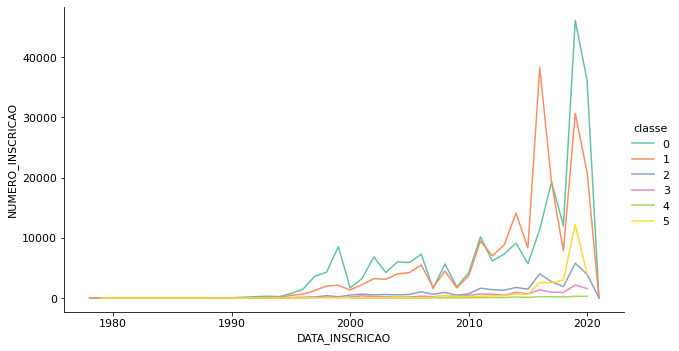

In [10]:
dfg=dfd.groupby([dfd.DATA_INSCRICAO.dt.year,dfd.classe])[['NUMERO_INSCRICAO']].count().reset_index()
dfg
sns.relplot(x='DATA_INSCRICAO', y='NUMERO_INSCRICAO', kind="line", palette="Set2", 
            data=dfg, height=5, aspect=16/9, hue='classe')

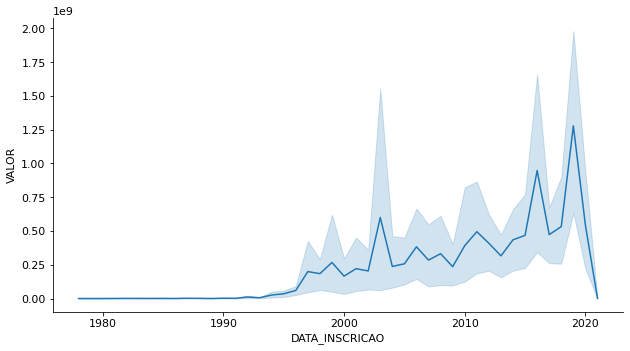

In [11]:
# Evolução da Dívida
dfg=dfd.groupby([dfd.DATA_INSCRICAO.dt.year,dfd.classe])[['VALOR']].sum().reset_index()
sns.relplot(x='DATA_INSCRICAO', y="VALOR", kind="line", palette="Set2", data=dfg, height=5, aspect=16/9)
#dfg.groupby(dfg.DATA_INSCRICAO)[['VALOR']].sum().reset_index()

,TIPO_SITUACAO_INSCRICAO,VALOR
1,Em cobrança,"45.809.368.550,75"
0,Benefício Fiscal,"5.953.233.712,52"
3,Garantia,"5.117.663.551,07"
4,Suspenso por decisão judicial,"2.285.088.081,67"
2,Em negociação,"22.101.339,08"


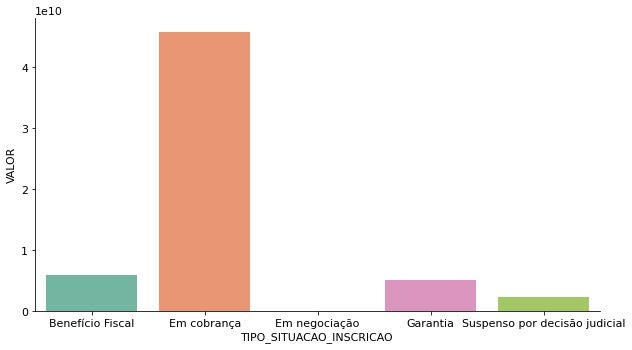

In [53]:
# Valor da dívida por situação
dfg=dfd.groupby([dfd.TIPO_SITUACAO_INSCRICAO])[['VALOR']].sum().reset_index()
sns.catplot(x='TIPO_SITUACAO_INSCRICAO', y="VALOR", kind="bar", palette="Set2", data=dfg, height=5, aspect=16/9)
dfg.sort_values(['VALOR'],ascending=False)

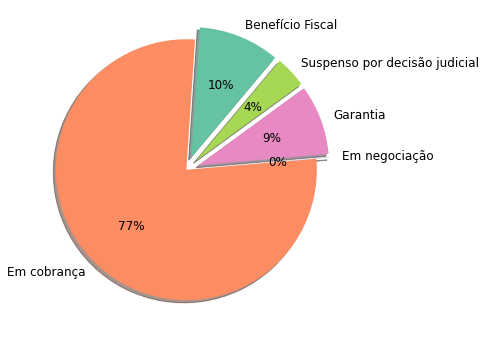

In [54]:
# Gráfico de Pizza para valor da Dívida por Situação
colors = sns.color_palette('Set2')[0:5]
explode = (0.1, 0, 0.1, 0.1, 0.1)
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 12})
plt.pie(x = dfg.VALOR, labels = dfg.TIPO_SITUACAO_INSCRICAO, colors = colors, 
        explode = explode, autopct='%.0f%%', shadow=True, startangle=50)
plt.show()
plt.rcParams.update({'font.size': 11})

In [55]:
# Testes e analise de resultados
#colunas = ["DATA_INSCRICAO","acumulado","anos","idade_c","idade_p", "idade_p_acum","idade_s"]
#dfd.query('CNPJ8 == "00062617"').sort_values(by=['CNPJ8', "DATA_INSCRICAO"])[colunas]

516306

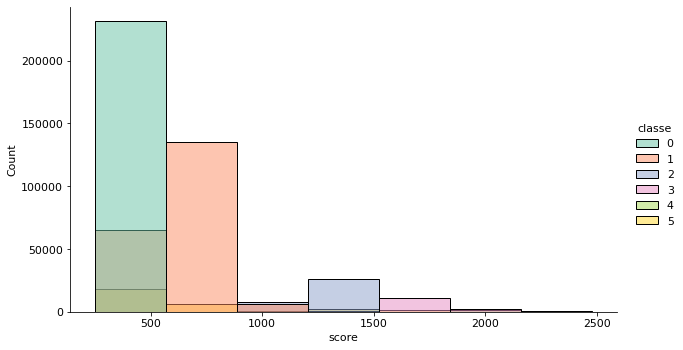

In [56]:
colunas = ['NOME_DEVEDOR','DATA_INSCRICAO','data_situacao', 'situacao', 'VALOR','acumulado','score','classe','classe1']
dfd2=dfd.groupby(['CNPJ8','trimestre'])[colunas].last().reset_index()
sns.displot(dfd,x='score', hue='classe',bins=7, height=5, aspect=16/9, palette="Set2" )
dfd.CNPJ8.count()

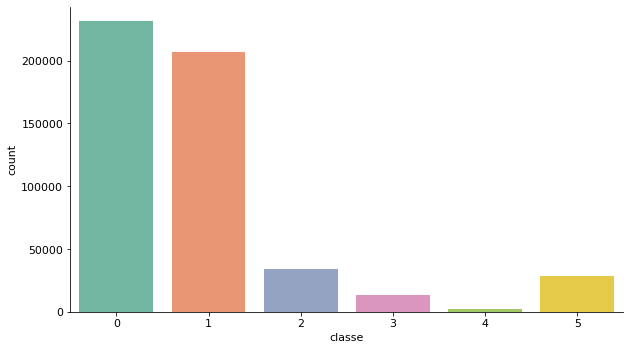

In [57]:
sns.catplot(x="classe", kind="count", palette="Set2", data=dfd, height=5, aspect=16/9)

284791


,classe,n_estados
0,0,142151
1,1,106651
5,5,20057
2,2,11496
3,3,3949
4,4,487


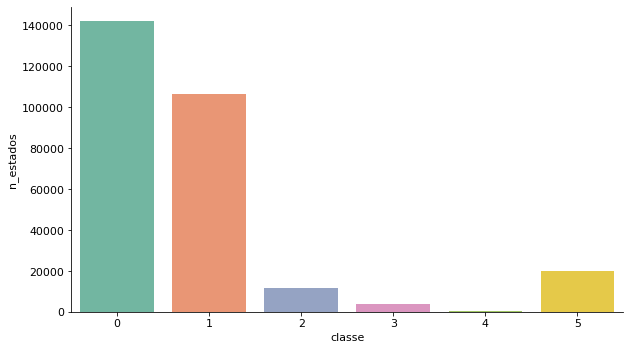

In [58]:
# Gráfico de barras de quantidade de contribuintes por Classe
dfg=dfd2.groupby([dfd2.classe])[['CNPJ8']].count().reset_index()
dfg.rename(columns = {'CNPJ8': 'n_estados'}, inplace = True)
print(dfd2.NOME_DEVEDOR.count())
sns.catplot(x='classe', y='n_estados', kind="bar", palette="Set2", data=dfg, height=5, aspect=16/9)
dfg.sort_values(["n_estados"],ascending=False)

### Criação dos Dataframes organizados para os Modelos de Machine Learning

In [67]:
# Criação de Dataframe com as Classificações de Risco de cada contribuinte em uma lista
dfe=dfd2.groupby('CNPJ8')['classe'].apply(list).reset_index()
dfe.rename(columns = {'classe': 'estados'}, inplace = True)
dfe.head(455)

,CNPJ8,estados
0,00000000,[1]
1,00002121,"[1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
2,00055849,[1]
3,00055870,"[0, 0, 0]"
4,00056138,[1]
...,...,...
450,00116332,[0]
451,00116337,[1]
452,00116804,"[1, 1]"
453,00116952,[0]


In [60]:
# Criação do dataframe com os dados para análise inicial
m=r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\DominiosSituaoCadastral.xls'
s=r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\DominiosSituaoCadastral.xls'
dfm = pd.read_excel (m, sheet_name='DominiosMotivoSituaoCadastral', converters={'codigo':int})
dfs = pd.read_excel (s, sheet_name='DominioSituacaoCadastral', converters={'codigo':int})
dfd3 = dfd2.groupby(['CNPJ8'])[['DATA_INSCRICAO','VALOR','acumulado','score','classe']].last().reset_index()
dfc2 = pd.merge(dfc, dfm, how='left', on='motivo_situacao')
dfc2 = pd.merge(dfc2, dfs, how='left', on='situacao')
dfc2 = pd.merge(dfc2, dfd3, how='left', on='CNPJ8')
dfc2 = pd.merge(dfc2, dfe, how='left', on='CNPJ8')
dfc2["n_estados"]=dfc2.apply(lambda x: len(x.estados), axis=1)
del dfm, dfs, dfd3
dfc2.head(5)

,CNPJ8,situacao,data_situacao,motivo_situacao,capital_social,...,acumulado,score,classe,estados,n_estados
0,00000000,2,2005-11-03,0,"6.700.000.000.000,00",...,"352.971,03",600,1,[1],1
1,00002121,2,2018-10-15,0,"580.000.000,00",...,"36.483.860,32",1650,3,"[1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]",11
2,00055849,4,2018-10-25,63,"1.000.000,00",...,"1.615,06",550,1,[1],1
3,00055870,4,2018-10-25,63,"0,00",...,"406.718,40",500,0,"[0, 0, 0]",3
4,00056138,4,2018-10-25,63,"0,00",...,"3.530,92",550,1,[1],1


In [61]:
dfc2.to_pickle(r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\dfc2.pkl')

### Análise Exploratória da Base da Dívida - Específica para Classificações de Risco

In [62]:
dfc2.groupby([dfc2.situacao_desc])[['CNPJ8']].count().reset_index()\

,situacao_desc,CNPJ8
0,ATIVA,82956
1,BAIXADA,28188
2,INAPTA,32396
3,NULA,29
4,SUSPENSA,1035


In [22]:
dfc2.query("0 < n_estados < 20").groupby(['n_estados'])['CNPJ8'].count()

n_estados
1     85033
2     29048
3     13471
4      6735
5      3757
6      2167
7      1401
8       838
9       584
10      410
11      322
12      209
13      149
14       99
15       82
16       61
17       63
18       39
19       23
Name: CNPJ8, dtype: int64

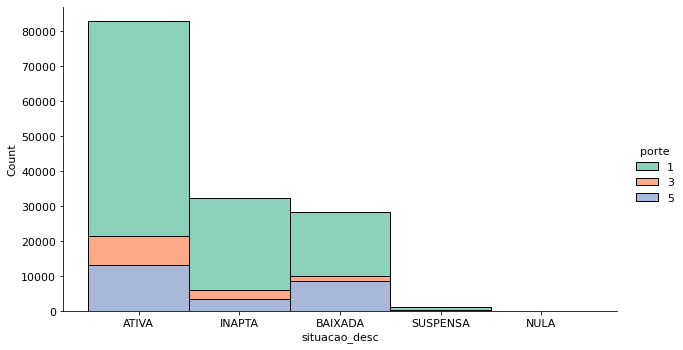

In [23]:
# Quantidade de contribuintes por situação cadastral e porte
sns.displot(dfc2,x='situacao_desc', hue='porte', palette="Set2", height=5, aspect=16/9, multiple = 'stack')

144604


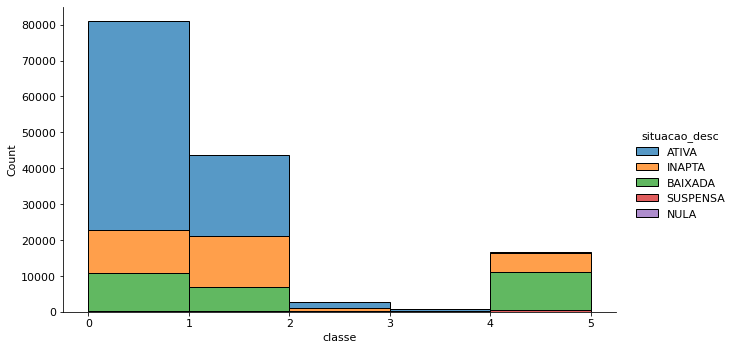

In [24]:
# Quantidade de contribuintes por score e situação cadastral
print(dfc2.CNPJ8.count())
sns.displot(dfc2, x='classe', binwidth=1, hue='situacao_desc', height=5, aspect=16/9, multiple = 'stack')

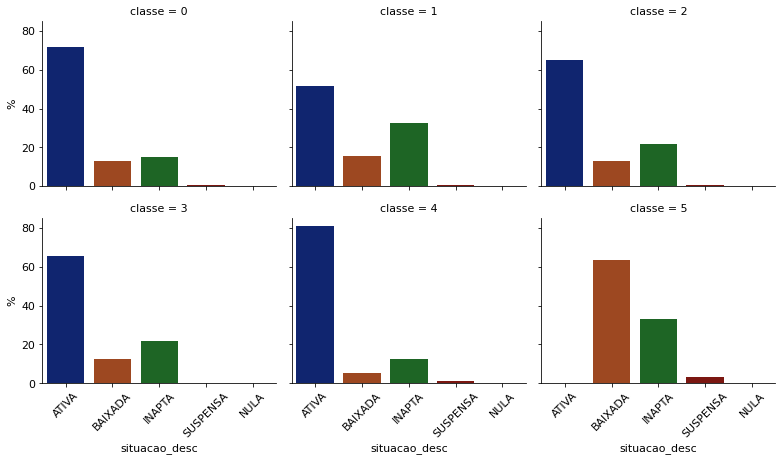

In [25]:
# Quantidade de Contribuintes por situação cadastral por classe
dfg=dfc2.groupby([dfc2.classe,dfc2.situacao_desc])[['CNPJ8']].count().reset_index()
dfg.rename(columns = {'CNPJ8': 'Contribuintes'}, inplace = True)
dfg['%'] = 100 * dfg['Contribuintes'] / dfg.groupby('classe')['Contribuintes'].transform('sum')
grid=sns.catplot(x='situacao_desc', y="%", kind="bar", col="classe", palette="dark", data=dfg, 
                 height=3, aspect=11/9, col_wrap=3)
grid.set_xticklabels(rotation=45)
#dfg.sort_values(['Contribuintes'],ascending=False)

,classe,acumulado
3,3,"27.093.281.886,85"
2,2,"9.649.308.357,23"
1,1,"9.587.470.178,88"
5,5,"7.784.942.036,92"
4,4,"3.279.840.059,13"
0,0,"1.792.612.716,08"


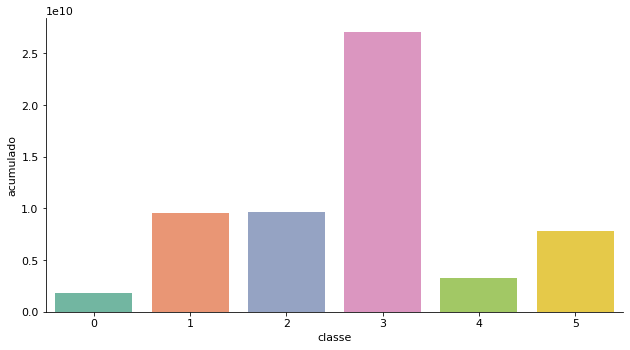

In [26]:
# Valor acumulado do débito inscrito por classe
dfg=dfc2.groupby([dfc2.classe])[['acumulado']].sum().reset_index()
sns.catplot(x='classe', y="acumulado", kind="bar", palette="Set2", data=dfg, height=5, aspect=16/9)
dfg.sort_values(['acumulado'],ascending=False)

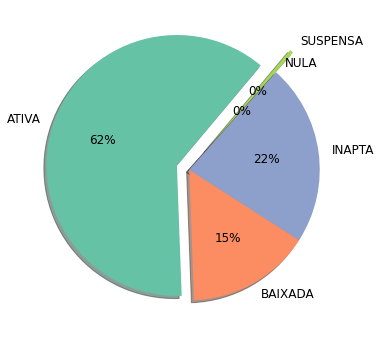

,situacao_desc,acumulado
0,ATIVA,"36.514.745.419,79"
2,INAPTA,"13.316.434.955,16"
1,BAIXADA,"9.084.957.920,13"
4,SUSPENSA,"269.008.969,05"
3,NULA,"2.307.970,96"


In [27]:
# Gráfico de Pizza do Percentual do valor do Débito por situação cadastral
dfg=dfc2.groupby([dfc2.situacao_desc])[['acumulado']].sum().reset_index()
colors = sns.color_palette('Set2')[0:5]
explode = (0.1, 0, 0, 0, 0.2)
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 12})
plt.pie(x = dfg.acumulado, labels = dfg.situacao_desc, colors = colors, 
        explode = explode, autopct='%.0f%%', shadow=True, startangle=50)
plt.show()
plt.rcParams.update({'font.size': 11})
dfg.sort_values(['acumulado'],ascending=False)

### Análise de UnderSampling

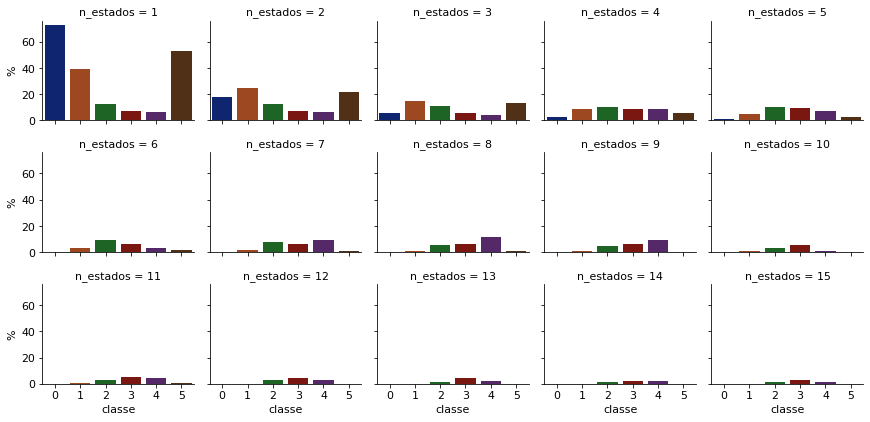

In [28]:
# Quantidade % de Contribuintes por n_estados por classe
dfg=dfc2.groupby([dfc2.n_estados,dfc2.classe])[['CNPJ8']].count().reset_index()
dfg.rename(columns = {'CNPJ8': 'Contribuintes'}, inplace = True)
dfg['%'] = 100 * dfg['Contribuintes'] / dfg.groupby('classe')['Contribuintes'].transform('sum')
grid=sns.catplot(x='classe', y="%", kind="bar", col="n_estados", palette="dark", 
                 data=dfg.query('0<n_estados<16'), height=2, aspect=11/9, col_wrap=5)
#grid.set_xticklabels(rotation=45)
#dfg.sort_values(['Contribuintes'],ascending=False)

In [73]:
dfc2.query("3 < n_estados < 20 ")

,CNPJ8,situacao,data_situacao,motivo_situacao,capital_social,...,acumulado,score,classe,estados,n_estados
1,00002121,2,2018-10-15,0,"580.000.000,00",...,"36.483.860,32",1650,3,"[1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]",11
7,00056535,8,2008-12-31,71,"0,00",...,"977.479,85",650,1,"[1, 1, 1, 1]",4
8,00057284,2,2005-11-03,0,"0,00",...,"118.734,79",650,1,"[0, 0, 0, 1]",4
22,00059015,2,2005-11-03,0,"2.000.000,00",...,"91.270,29",494,0,"[1, 0, 0, 0]",4
26,00059966,4,2018-10-25,63,"6.000.000,00",...,"77.942,45",456,5,"[0, 0, 0, 5]",4
...,...,...,...,...,...,...,...,...,...,...,...
144500,97530855,2,2011-07-08,0,"3.000.000,00",...,"15.648,40",510,1,"[1, 1, 1, 1]",4
144506,97533625,2,2011-06-30,0,"5.000.000,00",...,"177.430,33",678,1,"[0, 0, 1, 1, 1]",5
144507,97533689,2,2011-07-01,0,"10.000.000,00",...,"2.756.753,40",1236,2,"[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]",11
144524,97536594,2,2011-07-12,0,"1.000.000,00",...,"513.515,71",900,1,"[1, 1, 1, 1]",4


144604


,classe,Contribuintes,%
0,0,81012,"56,02"
1,1,43590,"30,14"
2,2,2683,"1,86"
3,3,717,"0,50"
4,4,95,"0,07"
5,5,16507,"11,42"


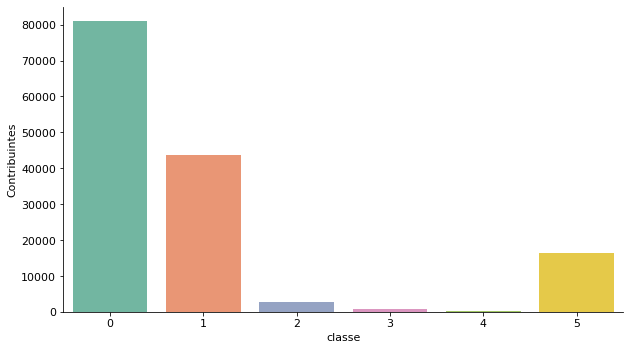

In [30]:
dfg1=dfc2.groupby([dfc2.classe])[['n_estados']].count().reset_index()
dfg1.rename(columns = {'n_estados': 'Contribuintes'}, inplace = True)
dfg1['%'] = 100 * dfg1['Contribuintes'] / dfg1.Contribuintes.sum()
print(dfg1.Contribuintes.sum())
sns.catplot(x='classe', y="Contribuintes", kind="bar", palette="Set2", data=dfg1, height=5, aspect=16/9)
dfg1.sort_values(['Contribuintes'],ascending=False)
dfg1

16939


,classe,Contribuintes,%
0,0,3244,"19,15"
1,1,9376,"55,35"
2,2,1678,"9,91"
3,3,521,"3,08"
4,4,73,"0,43"
5,5,2047,"12,08"


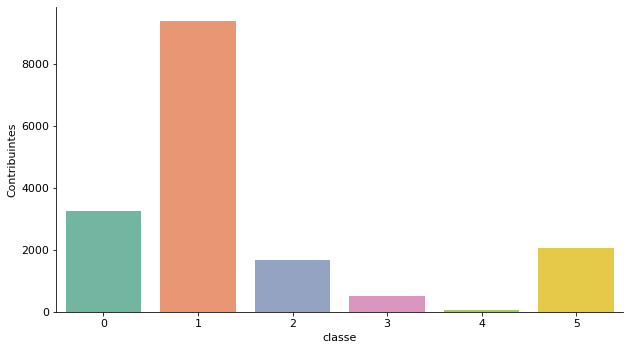

In [31]:
dfg2=dfc2.query("3 < n_estados < 20").groupby([dfc2.classe])[['n_estados']].count().reset_index()
dfg2.rename(columns = {'n_estados': 'Contribuintes'}, inplace = True)
dfg2['%'] = 100 * dfg2['Contribuintes'] / dfg2.Contribuintes.sum()
print(dfg2.Contribuintes.sum())
sns.catplot(x='classe', y="Contribuintes", kind="bar", palette="Set2", data=dfg2, height=5, aspect=16/9)
dfg2.sort_values(['Contribuintes'],ascending=False)
dfg2

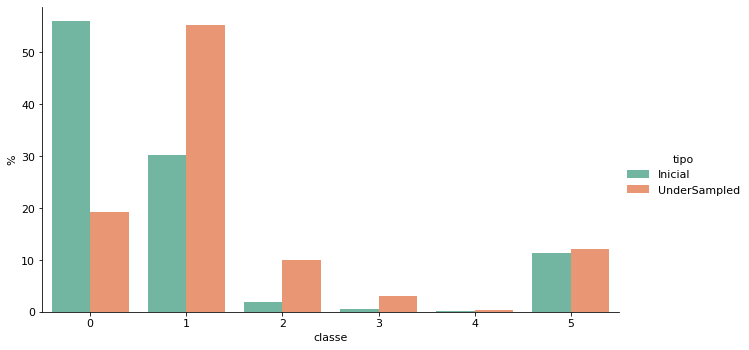

In [32]:
dfg1["tipo"]="Inicial"
dfg2["tipo"]="UnderSampled"
dfg=pd.concat([dfg1,dfg2])
sns.catplot(x='classe', y="%", kind="bar", hue="tipo", palette="Set2", data=dfg, height=5, aspect=16/9)

In [33]:
#dfc3.query('situacao_desc == "SUSPENSA" & n_estados>2').sort_values(by=['CNPJ8'])

### Undersampling

In [34]:
dfc2 = pd.read_pickle(r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\dfc2.pkl')

In [35]:
# O dataframe dfc3 contém os dados do contribuinte (VALOR, acumulado, etc) da ÚLTIMA classificação de risco de cada série
# Esse dados serão utilizados para análise com o HmmLearn. Só é utilizada a coluna "estados" para predição
dfc3 = dfc2.query("3 < n_estados < 20").reset_index()
n_dfc3 = dfc3.n_estados.sum()
r_dfc3 = len(dfc3.index)
print ("Número de contribuintes : ", r_dfc3)
print("Número de estados totais: ", n_dfc3)
dfc3.head(4)

Número de contribuintes :  16939
Número de estados totais:  98383


,index,CNPJ8,situacao,data_situacao,motivo_situacao,...,acumulado,score,classe,estados,n_estados
0,1,00002121,2,2018-10-15,0,...,"36.483.860,32",1650,3,"[1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]",11
1,7,00056535,8,2008-12-31,71,...,"977.479,85",650,1,"[1, 1, 1, 1]",4
2,8,00057284,2,2005-11-03,0,...,"118.734,79",650,1,"[0, 0, 0, 1]",4
3,22,00059015,2,2005-11-03,0,...,"91.270,29",494,0,"[1, 0, 0, 0]",4


In [36]:
# O dataframe dfc4 contém os dados do contribuinte (VALOR, acumulado, etc) da PENÚLTIMA classificação de risco de cada série
# Esse dados serão utilizados para análise com o PyCaret
dfd3 = dfd2.groupby(['CNPJ8'])[['DATA_INSCRICAO','VALOR','acumulado','score']].nth(-2).reset_index()
dfd3 = pd.merge(dfc3[["CNPJ8","classe"]], dfd3, how='left', on='CNPJ8')
m = r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\DominiosSituaoCadastral.xls'
s= r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\DominiosSituaoCadastral.xls'
dfm = pd.read_excel (m, sheet_name='DominiosMotivoSituaoCadastral', converters={'codigo':int})
dfs = pd.read_excel (s, sheet_name='DominioSituacaoCadastral', converters={'codigo':int})
dfc4 = pd.merge(dfc3["CNPJ8"], dfc, how='left', on='CNPJ8')
dfc4 = pd.merge(dfc4, dfm, how='left', on='motivo_situacao')
dfc4= pd.merge(dfc4, dfs, how='left', on='situacao')
dfc4 = pd.merge(dfc4, dfd3, how='left', on='CNPJ8')
dfc4 = pd.merge(dfc4, dfe, how='left', on='CNPJ8')
dfc4["n_estados"]=dfc4.apply(lambda x: len(x.estados), axis=1)
del dfm, dfs, dfd3
print("Número de estados totais: ",dfc4.CNPJ8.count())
dfc4.head(5)

Número de estados totais:  16939


,CNPJ8,situacao,data_situacao,motivo_situacao,capital_social,...,VALOR,acumulado,score,estados,n_estados
0,00002121,2,2018-10-15,0,"580.000.000,00",...,"554.594,72","36.481.198,84",1650,"[1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]",11
1,00056535,8,2008-12-31,71,"0,00",...,"152.948,35","566.581,47",650,"[1, 1, 1, 1]",4
2,00057284,2,2005-11-03,0,"0,00",...,"295,00","61.569,14",450,"[0, 0, 0, 1]",4
3,00059015,2,2005-11-03,0,"2.000.000,00",...,"10.195,56","13.015,44",459,"[1, 0, 0, 0]",4
4,00059966,4,2018-10-25,63,"6.000.000,00",...,"3.447,42","74.775,28",454,"[0, 0, 0, 5]",4


In [37]:
dfc3.to_pickle(r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\dfc3.pkl')
dfc4.to_pickle(r'C:\Users\49026461534\Documents\_Pos Big Data\TCC\dfc4.pkl')

### Geração Modelo HMM para Previsão de Risco

In [38]:
import sklearn
from hmmlearn import hmm
from hmmlearn.hmm import MultinomialHMM
# Definido o número de estados ocultos como 4
states = ["K", "L","M","N"] 
n_states = len(states)
#Definido o número de observações como 6, correpondentes as classificações de risco de 0 a 5
observations = ["A", "B", "C", "D", "E", "F"]
n_observations = len(observations)
model = hmm.MultinomialHMM(n_components=n_states, n_iter=5000, tol=0.01)

# Exemplo de formatação de dados de treinamento
#D1 = [[1], [0], [0], [0], [1], [1], [1]]
#D2 = [[1], [0], [0], [0], [1], [1], [1], [0], [1], [1]]
#D3 = [[1], [0], [0]]
#X = np.concatenate([D1, D2, D3])

# dfc3["estados"][j][:-1] exclui o estado final para treinamento
X = np.concatenate([[[i] for i in dfc3["estados"][j][:-1]] for j in range(r_dfc3)])
print("Tamanho da base de treinamento (estados): ", X.size)

#Treinamento
model.fit(X)

#Matrizes do modelo treinado
print('MATRIZ ESTADO INICIAL:')
print (model.startprob_)
print('MATRIZ DE TRANSIÇÃO:')
print (model.transmat_)
print('MATRIZ DE PROBABILIDADE DE EMISSÃO:')
print (model.emissionprob_)
print('PROBABILIDADE LOG SOB O MODELO:')
print (model.score(X))

Tamanho da base de treinamento (estados):  81444
MATRIZ ESTADO INICIAL:
[0.00000000e+000 0.00000000e+000 2.12440994e-167 1.00000000e+000]
MATRIZ DE TRANSIÇÃO:
[[0.72216678 0.00899596 0.00570418 0.26313308]
 [0.13058032 0.78147186 0.0125187  0.07542912]
 [0.27124711 0.00449575 0.58810314 0.136154  ]
 [0.15080342 0.04645387 0.01049971 0.79224299]]
MATRIZ DE PROBABILIDADE DE EMISSÃO:
[[9.99993018e-01 2.20499655e-08 1.21370009e-26 1.85651766e-34
  2.30856169e-85 6.96036291e-06]
 [1.45889668e-03 6.56827004e-04 7.51805833e-01 2.20143706e-01
  2.59347379e-02 8.66704304e-25]
 [2.31928485e-04 9.37005733e-07 1.98055440e-24 3.26898141e-42
  1.37060848e-78 9.99767135e-01]
 [1.17946184e-04 9.96626815e-01 7.10630341e-11 2.66506322e-49
  1.46935826e-88 3.25523830e-03]]
PROBABILIDADE LOG SOB O MODELO:
-61850.91300305817


In [39]:
Yt = np.concatenate([[dfc3["estados"][j][-1]] for j in range(r_dfc3)])
n_Yt=len(Yt)
print(n_Yt)
Yt

16939


array([3, 1, 1, ..., 2, 1, 0])

In [40]:
# Previsões do Modelo HMM para base de contribuintes reduzida após undersampling
from sklearn.utils import check_random_state
# função para previsão de observação 
# prever1-> com problema por causa da indisponibilidade nesta versão hmmlearn de indicar o currstate
def prever1(x):
 y,z = model.sample(1,x[0][-2])
 return   y[0]

# prever2-> gera previsão do próximo estado observável
def prever2(x):
    states = model.predict(x)
    transmat_cdf = np.cumsum(model.transmat_, axis=1)
    random_state = check_random_state(model.random_state)
    next_state = (transmat_cdf[states[-1]] > random_state.rand()).argmax()
    next_obs = model._generate_sample_from_state(next_state, random_state)
    return next_obs

# Previsão dos estados observáveis
# observe que são fornecidos ao modelo os estados exceto o último, que será utilizado no teste
Yp = np.concatenate([prever2([dfc3["estados"][j][:-1]]) for j in range(r_dfc3)])

# Estados Ocultos previstos para a última classificação
Zp = np.concatenate([[model.predict([dfc3["estados"][j][:-1]])[-1]] for j in range(r_dfc3)])
n_Yp=len(Yp)
print(n_Yp)
Yp

16939


array([1, 1, 0, ..., 2, 1, 0], dtype=int64)

### Análise de Resultados do Modelo HMM

Acurácia:  0.6354566385264774
Precisão:  [0.46325879 0.76704046 0.5357591  0.17755102 0.01612903 0.76197388]
F1      :  [0.56228793 0.7554136  0.52200489 0.17210682 0.01481481 0.38377193]
Recall  :  [0.71516646 0.74413396 0.50893921 0.16698656 0.01369863 0.25647289]


[Text(0.5, 1.0, 'Mapa de Calor para HMM - dfc3'),
 Text(0.5, 24.0, 'Classes Previstas'),
 Text(69.0, 0.5, 'Classes Verdadeiras')]

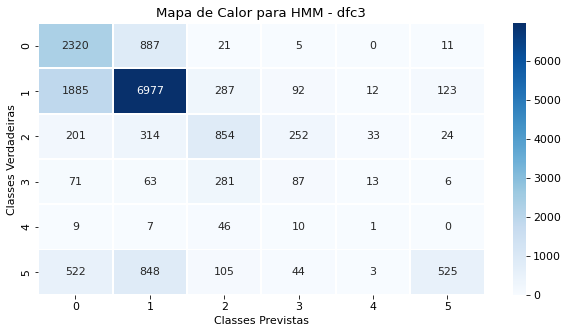

In [93]:
# Análise de Resultados para o modelo HMM para a base com undersampling
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
cf_matrix = confusion_matrix(Yt, Yp)
plt.figure(figsize=(10,5))
acuracia=accuracy_score(Yt, Yp, normalize=True, sample_weight=None)
precisao = precision_score(Yt, Yp, average=None, zero_division='warn')
f1 = f1_score(Yt, Yp, average=None, zero_division='warn')
recall = recall_score(Yt, Yp, average=None, zero_division='warn')
print("Acurácia: ", acuracia)
print("Precisão: ",precisao)
print("F1      : ",f1)
print("Recall  : ",recall)
hm=sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g', cmap='Blues')
hm.set(title="Mapa de Calor para HMM - dfc3", xlabel="Classes Previstas", ylabel="Classes Verdadeiras")

59571
Acurácia:  0.4970203622568028
Precisão:  [0.52078686 0.50944844 0.30771704 0.0964247  0.         0.60244845]
F1      :  [0.41562365 0.6084009  0.35125711 0.11209068 0.         0.19967966]
Recall  :  [0.34579649 0.7550595  0.40914921 0.13383459 0.         0.11967234]


[Text(0.5, 1.0, 'Mapa de Calor para HMM - dfcT'),
 Text(0.5, 24.0, 'Classes Previstas'),
 Text(69.0, 0.5, 'Classes Verdadeiras')]

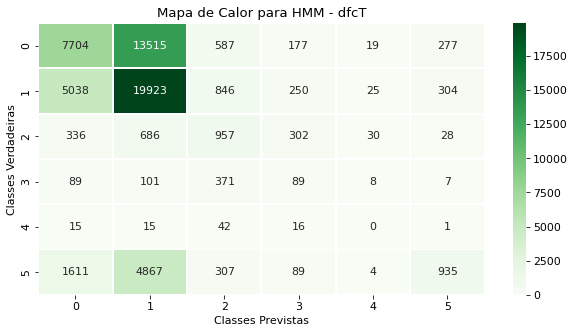

In [42]:
# Previsão e Análise de Resultados para o modelo HMM para a base geral com pelo menos 2 estados
dfcT = dfc2.query("1 < n_estados").reset_index()
r_dfcT = len(dfcT.index)
print(r_dfcT)
Yp2 = np.concatenate([prever2([dfcT["estados"][j][:-1]]) for j in range(r_dfcT)])
Yt2 = np.concatenate([[dfcT["estados"][j][-1]] for j in range(r_dfcT)])
cf_matrix = confusion_matrix(Yt2, Yp2)
plt.figure(figsize=(10,5))
acuracia=accuracy_score(Yt2, Yp2, normalize=True, sample_weight=None)
precisao = precision_score(Yt2, Yp2, average=None, zero_division='warn')
f1 = f1_score(Yt2, Yp2, average=None, zero_division='warn')
recall = recall_score(Yt2, Yp2, average=None, zero_division='warn')
print("Acurácia: ", acuracia)
print("Precisão: ",precisao)
print("F1      : ",f1)
print("Recall  : ",recall)
hm=sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g', cmap='Greens')
hm.set(title="Mapa de Calor para HMM - dfcT", xlabel="Classes Previstas", ylabel="Classes Verdadeiras")

In [43]:
cf_matrix

array([[ 7704, 13515,   587,   177,    19,   277],
       [ 5038, 19923,   846,   250,    25,   304],
       [  336,   686,   957,   302,    30,    28],
       [   89,   101,   371,    89,     8,     7],
       [   15,    15,    42,    16,     0,     1],
       [ 1611,  4867,   307,    89,     4,   935]], dtype=int64)

In [94]:
Yprob=
plot_roc_curve(Yt, Yprob)

TypeError: plot_roc_curve() missing 1 required positional argument: 'y'

[Text(0.5, 1.0, 'Mapa de Calor para Estados Ocultos'),
 Text(0.5, 24.0, 'Classes Previstas'),
 Text(69.0, 0.5, 'Estados Ocultos')]

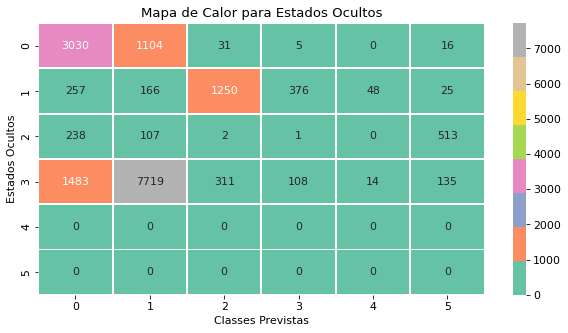

In [44]:
#Utilização da Matriz de Confusão para identificar Estado oculto de "Decidiu não Cumprir"
#Como o que tem maior frequência de Classe de Risco 5 - Relacionando com a situação cadastra
cf_matrix = confusion_matrix(Zp, Yp)
plt.figure(figsize=(10,5))
hm=sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g', cmap='Set2')
hm.set(title="Mapa de Calor para Estados Ocultos", xlabel="Classes Previstas", ylabel="Estados Ocultos")

In [45]:
# check version number
import imblearn
from imblearn.over_sampling import RandomOverSampler
print(imblearn.__version__)
oversample = RandomOverSampler(sampling_strategy='minority')

0.7.0


In [46]:
Y = [[i] for i in dfc3["estados"][10622]]
n_Y = len(Y)

In [47]:
Y[:-1]

[[1], [2], [2]]

In [48]:
from sklearn.utils import check_random_state
states = model.predict(Y[:-1])
#transmat_cdf = np.cumsum(model.transmat_, axis=1)
#random_state = check_random_state(model.random_state)
#next_state = (transmat_cdf[states[-1]] > random_state.rand()).argmax()
#next_obs = model._generate_sample_from_state(next_state, random_state)
#next_obs
r=model.sample(1,Y[-1][0])
r

(array([[1]], dtype=int64), array([3]))

In [49]:
states

array([3, 1, 1])

In [50]:
model.decode(Y, lengths=n_Y, algorithm="viterbi")

(-4.421658169572388, array([3, 1, 1, 1]))

In [51]:
#dfc2.query('situacao_desc == "SUSPENSA" & n_estados>7 ').sort_values(by=['n_estados'])

In [79]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144604 entries, 0 to 144603
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   CNPJ8    144604 non-null  object
 1   estados  144604 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB
